## Task 1 - Part 1

#### Step 1 − Import the necessary packages

In [58]:
# Importar bibliotecas necessárias
import numpy as np
import random
import matplotlib.pyplot as plt  # Corrigido plt00 para plt
from sklearn.linear_model import Ridge, Lasso, RANSACRegressor, LinearRegression  # Unificado as importações do sklearn.linear_model
from sklearn.model_selection import GridSearchCV, train_test_split  # Unificado imports de model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels import robust  # statsmodels não conflita com sklearn, então permanece
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam

from sklearn.svm import SVC

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, balanced_accuracy_score


from tensorflow.keras.layers import BatchNormalization

from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from skimage.util import view_as_windows
from sklearn.feature_extraction import image





print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    


Num GPUs Available:  1


#### Step 1.5 − Picture visulazer

In [59]:
# Função para visualizar as imagens e seus rótulos (predictions)
def img_view(dataset, labels=None, num_imgs=5, start_idx=0):
    """
    Função que visualiza um número especificado de imagens a partir de um índice inicial.
    
    Parâmetros:
    - dataset: Conjunto de imagens a visualizar.
    - labels: (Opcional) Rótulos das imagens ou previsões, se disponíveis.
    - num_imgs: Número de imagens a visualizar.
    - start_idx: Índice inicial para começar a visualização das imagens.
    """
    # Verificar quantas imagens existem no dataset
    num_imgs = min(num_imgs, len(dataset) - start_idx)  # Garante que não tentas visualizar mais imagens do que as disponíveis

    # Criar a figura para visualização
    plt.figure(figsize=(15, 5))  # Ajuste o tamanho da figura
    
    for i in range(num_imgs):
        idx = start_idx + i  # Usar o índice inicial fornecido
        
        # Mostrar a imagem original
        plt.subplot(2, num_imgs, i + 1)
        plt.imshow(dataset[idx], cmap='gray')  # Exibir a imagem original
        plt.axis('off')
        plt.title(f"Image {idx}")
        
        # Se os rótulos/previsões estiverem disponíveis, mostrá-los
        if labels is not None:
            plt.subplot(2, num_imgs, num_imgs + i + 1)
            plt.imshow(labels[idx], cmap='gray')  # Exibir a previsão ou rótulo correspondente
            plt.axis('off')
            plt.title(f"Prediction {idx}")

    plt.show()


#### Step 2 − Load the dataset

X_train shape antes do reshape: (547, 2304)
X_train shape depois do reshape: (547, 48, 48)


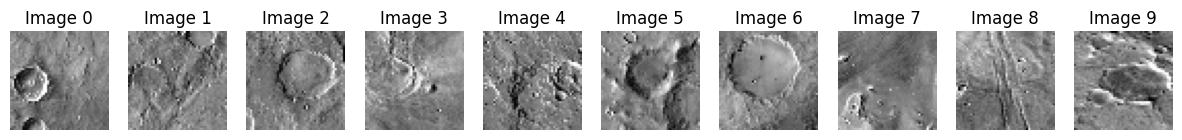

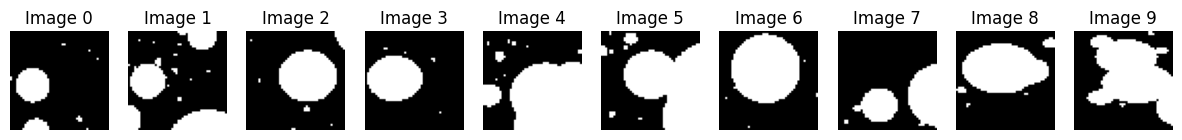

In [60]:
# Carregar os dados
X_test_a = np.load('Xtest2_a.npy')
X_test_b = np.load('Xtest2_b.npy')
X_train_a = np.load('Xtrain2_a.npy')
X_train_b = np.load('Xtrain2_b.npy')
Y_train_a = np.load('Ytrain2_a.npy')
Y_train_b = np.load('Ytrain2_b.npy')

# Verificar as dimensões dos datasets antes do reshape
print(f"X_train shape antes do reshape: {X_train_b.shape}")

# Reformatar as imagens para o formato correto (48, 48)
X_train_b= X_train_b.reshape(-1, 48, 48)
X_test_b = X_test_b.reshape(-1, 48, 48)
Y_train_b = Y_train_b.reshape(-1, 48, 48)

print(f"X_train shape depois do reshape: {X_train_b.shape}")
#############################################3
# Variável para controlar quantas imagens queres visualizar
num_imagens = 10  # Podes alterar este número para visualizar mais ou menos imagens
#######################################3


# Visualizar imagens de treino com rótulos
#img_view(X_train_b, Y_train_b, num_imgs=num_imagens)

# Visualizar imagens de teste (sem rótulos)
img_view(X_train_b, num_imgs=num_imagens)

img_view(Y_train_b, num_imgs=num_imagens)




#### Step 2.5 - processamento

(547, 48, 48, 1)
(547, 48, 48, 1)
(8862, 40, 40, 1)
(8862, 40, 40, 1)


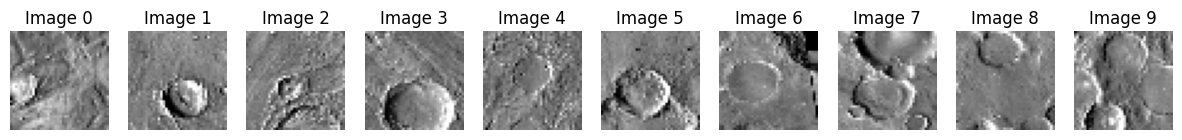

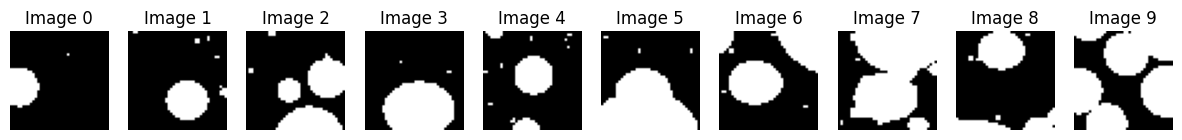

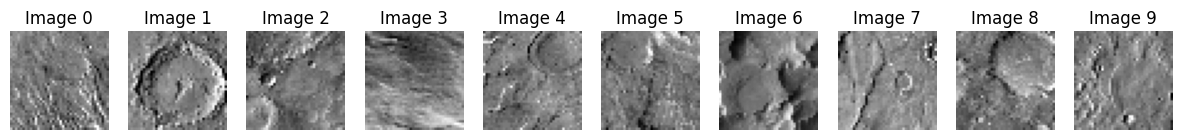

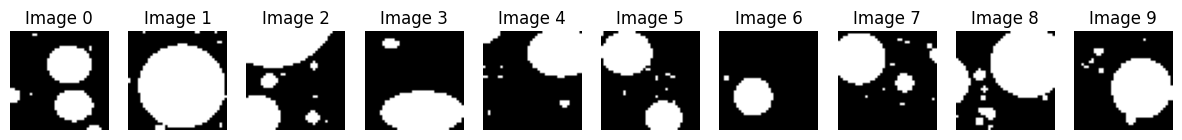

In [61]:
# 2. Preprocessamento: Reshape e Normalização
# Ajustar a forma das imagens para (48, 48, 1) para incluir o canal de cor (grayscale)
# A CNN espera 4 dimensões: (número de amostras, altura, largura, número de canais)
X_train_b= X_train_b.reshape(-1, 48, 48, 1)
X_test_b = X_test_b.reshape(-1, 48, 48, 1)
Y_train_b = Y_train_b.reshape(-1, 48, 48, 1)

# Normalizar os valores dos píxeis para estar entre 0 e 1, dividindo por 255
# Isto ajuda o modelo a convergir melhor durante o treino
X_train_b = X_train_b / 255.0
X_test_b = X_test_b / 255.0

patch_size = (40, 40)

# Ensure patches are extracted from the entire image before splitting into train/validation
X_train_patches = []
Y_train_patches = []

for img, mask in zip(X_train_b, Y_train_b):
    img_patches = image.extract_patches_2d(img, patch_size)  # Extract patches from image
    mask_patches = image.extract_patches_2d(mask, patch_size)  # Extract corresponding patches from mask

    X_train_patches.append(img_patches)
    Y_train_patches.append(mask_patches)

# Convert lists to numpy arrays
X_train_patches = np.array(X_train_patches)  # Shape: (n_images, n_patches, patch_height, patch_width, 1)
Y_train_patches = np.array(Y_train_patches)  # Shape: (n_images, n_patches, patch_height, patch_width, 1)

# Flatten patches to separate for train-test split
n_patches_per_image = (48 // patch_size[0]) ** 2
X_train_patches_flat = X_train_patches.reshape(-1, patch_size[0], patch_size[1], 1)
Y_train_patches_flat = Y_train_patches.reshape(-1, patch_size[0], patch_size[1], 1)

# Train-test split (split patches, but maintain the same correspondence)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_patches_flat, Y_train_patches_flat, test_size=0.2, random_state=42)


print(X_train_b.shape)
print(Y_train_b.shape)
print(Y_val.shape)
print(X_val.shape)

img_view(X_train, num_imgs=10)
img_view(Y_train, num_imgs=10)
img_view(X_val, num_imgs=10)
img_view(Y_val, num_imgs=10)


#### Step 3 - Classs imbalance

In [62]:
def weighted_binary_crossentropy(y_true, y_pred):
    # Assume background (0) pixels are more common, crater (1) pixels are less common
    weight_for_1 = 2.0  # Increase this if craters are much rarer
    weight_for_0 = 1.0
    weights = y_true * weight_for_1 + (1 - y_true) * weight_for_0
    binary_crossentropy = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    return tf.keras.backend.mean(weights * binary_crossentropy)


#### Step 3 −Definir a arquitetura da cnn 

In [63]:

def simplified_unet(input_size=(40, 40, 1)):
    inputs = Input(input_size)

    # Encoder (downsampling)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck (deepest part of U-Net)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder (upsampling)
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = concatenate([up4, conv2], axis=3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv1], axis=3)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)

    # Output layer (sigmoid activation for binary classification)
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs=[inputs], outputs=[output])
    return model


# Create and compile the simplified model
simplified_model = simplified_unet()



#### Step 3 - Original model

In [64]:


simplified_model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])

# Train the model
history = simplified_model.fit(X_train, Y_train, epochs=7, batch_size=32, validation_data=(X_val, Y_val))

# Evaluate on the validation set
val_loss, val_accuracy = simplified_model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


Epoch 1/7
1108/1108 [==============================] - 17s 14ms/step - loss: 0.5877 - accuracy: 0.8056 - val_loss: 0.4755 - val_accuracy: 0.8406
Epoch 2/7
1108/1108 [==============================] - 16s 15ms/step - loss: 0.4077 - accuracy: 0.8789 - val_loss: 0.3428 - val_accuracy: 0.9024
Epoch 3/7
1108/1108 [==============================] - 16s 15ms/step - loss: 0.3037 - accuracy: 0.9127 - val_loss: 0.2833 - val_accuracy: 0.9158
Epoch 4/7
1108/1108 [==============================] - 16s 15ms/step - loss: 0.2498 - accuracy: 0.9292 - val_loss: 0.2341 - val_accuracy: 0.9345
Epoch 5/7
1108/1108 [==============================] - 16s 15ms/step - loss: 0.2166 - accuracy: 0.9391 - val_loss: 0.2141 - val_accuracy: 0.9389
Epoch 6/7
1108/1108 [==============================] - 16s 15ms/step - loss: 0.1970 - accuracy: 0.9448 - val_loss: 0.2000 - val_accuracy: 0.9478
Epoch 7/7
277/277 [==============================] - 1s 5ms/step - loss: 0.1831 - accuracy: 0.9471
Validation Loss: 0.183075919747

#### Step 7 − View model


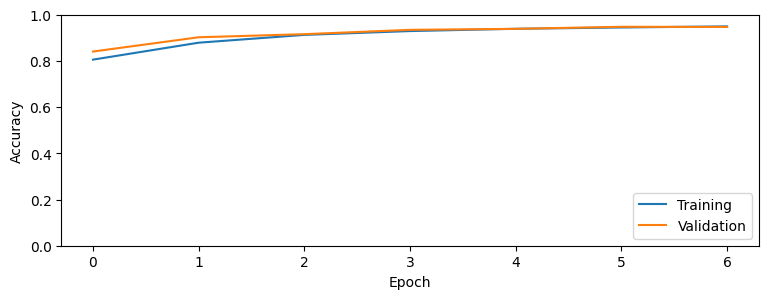

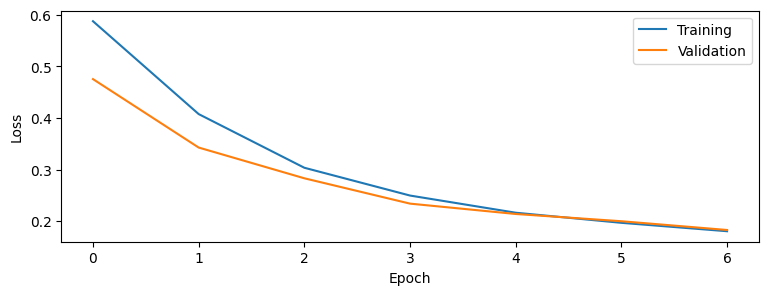

In [65]:
# 7. Gráficos da precisão de treino e validação
# - Visualizamos como a precisão evoluiu ao longo das épocas
plt.figure(figsize=(9, 3))
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(9, 3))
# Se quiseres visualizar também a perda, podes usar:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

#### Step - Evaluation metrics

277/277 [==============================] - 1s 4ms/step


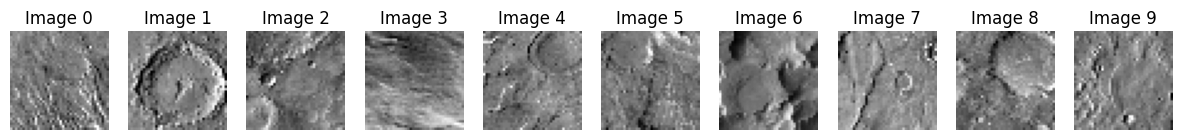

(8862, 48, 48)
Original images


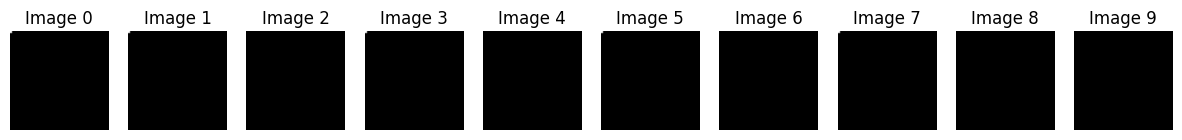

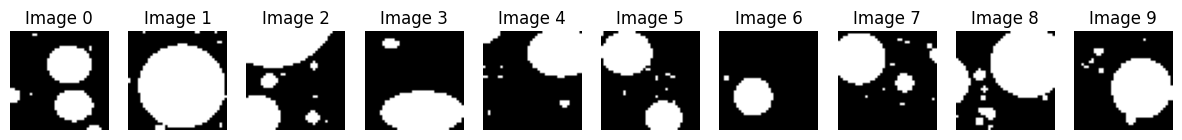

Original Ground Truth


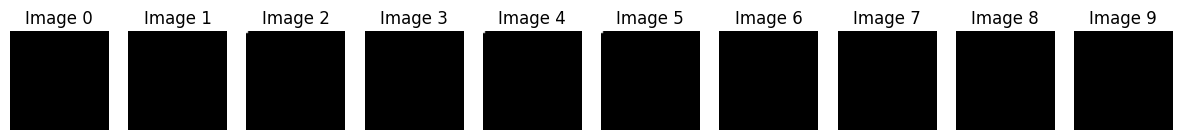

Predicted Output


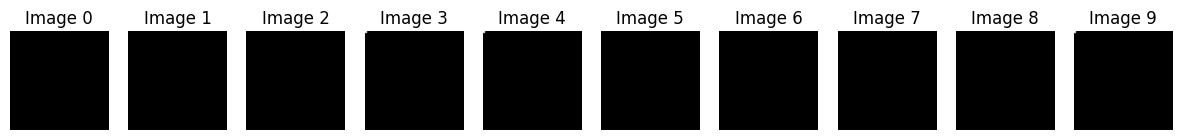

In [66]:
# Adjusting patch extraction logic

# Predict on patches
test_patches = simplified_model.predict(X_val)
pred_patches = (test_patches > 0.5).astype(np.uint8)



# Reshape predictions into the original form (reconstruct the full-sized images)
n_val_images = len(X_val)  # Number of images in the validation set
reconstructed_preds = []
reconstructed_truths = []
# Iterate over the number of images in the validation set
for i in range(n_val_images):
    # Select the patches corresponding to image i
    pred_patches_i = pred_patches[i * (48 // 40)**2: (i + 1) * (48 // 40)**2]
    true_patches_i = Y_val[i * (48 // 40)**2: (i + 1) * (48 // 40)**2]
    
    # Ensure that pred_patches_i and true_patches_i have the correct shape
    # They should be 3D arrays: (n_patches, patch_height, patch_width, 1)
    # If squeezed dimensions cause issues, reshape them properly
    if pred_patches_i.shape[-1] == 1:
        pred_patches_i = np.squeeze(pred_patches_i, axis=-1)  # Squeeze to remove redundant channel

    if true_patches_i.shape[-1] == 1:
        true_patches_i = np.squeeze(true_patches_i, axis=-1)  # Squeeze to remove redundant channel

    # Now reconstruct the full image from patches (both prediction and ground truth)
    try:
        reconstructed_pred_img = image.reconstruct_from_patches_2d(pred_patches_i, (48, 48))
        reconstructed_true_img = image.reconstruct_from_patches_2d(true_patches_i, (48, 48))
    except ValueError as e:
        print(f"Error reconstructing image {i}: {e}")
        continue

    reconstructed_preds.append(reconstructed_pred_img)
    reconstructed_truths.append(reconstructed_true_img)

# Convert the reconstructed lists into numpy arrays
reconstructed_preds = np.array(reconstructed_preds)
reconstructed_truths = np.array(reconstructed_truths)

# Reconstruct the validation input images (X_val_b) from patches
reconstructed_inputs = []

n_val_images = len(X_val) // ((48 // 40)**2)  # Number of images in the validation set

# Iterate over the number of images in the validation set
for i in range(n_val_images):
    # Select the patches corresponding to image i
    input_patches_i = X_val[i * (48 // 40)**2: (i + 1) * (48 // 40)**2]

    # Ensure that input_patches_i has at least 2 dimensions (patch_height, patch_width)
    # If it has an extra channel dimension (like (n_patches, 40, 40, 1)), remove that channel dimension
    if input_patches_i.ndim == 4 and input_patches_i.shape[-1] == 1:
        input_patches_i = np.squeeze(input_patches_i, axis=-1)  # Remove the channel dimension if it's 1

    # Now reconstruct the full image from patches
    try:
        reconstructed_input_img = image.reconstruct_from_patches_2d(input_patches_i, (48, 48))
    except ValueError as e:
        print(f"Error reconstructing image {i}: {e}")
        continue

    reconstructed_inputs.append(reconstructed_input_img)

# Convert the reconstructed list into a numpy array
reconstructed_inputs = np.array(reconstructed_inputs)  # Shape: (n_samples, 48, 48)
reconstructed_inputs = (reconstructed_inputs > 0.5).astype(np.uint8)

reconstructed_truths = (reconstructed_truths > 0.5).astype(np.uint8)

reconstructed_preds = (reconstructed_preds > 0.5).astype(np.uint8)
# Visualize original, ground truth, and predicted images
img_view(X_val, num_imgs=10)
print(reconstructed_inputs.shape)
print("Original images")
img_view(reconstructed_inputs, num_imgs=10)

img_view(Y_val, num_imgs=10)
print("Original Ground Truth")
img_view(reconstructed_truths, num_imgs=10)

print("Predicted Output")
img_view(reconstructed_preds, num_imgs=10)
